In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Real circle

In [2]:
R = 10
xc = np.array([5,5])

## Build circle

In [3]:
def circle_params(p):
    A,D,E,F = p
    xc = -D/(2*A)
    yc = -E/(2*A)
    R = np.sqrt(xc**2+yc**2-F/A)
    return R,np.array([xc,yc])

def plot_circle_from_xk(xk,c='b'):
    plt.scatter(xk[1,:],xk[0,:],c=c)
    pass

def plot_circle_from_params(p,c='b'):
    R,xc = circle_params(p)
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis]
    plt.scatter(xk[1,:],xk[0,:],c=c)
    pass
    
def build_circle(R,xc,std=0,outliers=False,c='b',outliers_ratio=0.05,plot=True):
    noise = None
    
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
    
    if plot:plot_circle_from_xk(xk,c)
    if outliers:
        noise = np.array([0.5*R*np.cos(teta),0.5*R*np.sin(teta)]) + 0.5*R*xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
        #noise = np.random.normal(0,std,(2,int(outliers_ratio*72))) +2*xc[:,np.newaxis]+R
        if plot:plt.scatter(noise[0,:],noise[1,:],c='b')
        xk = np.hstack((xk,noise))
    return xk

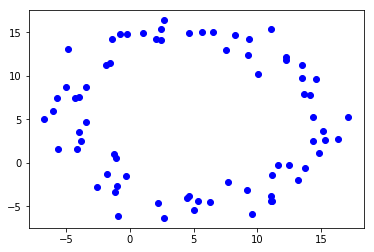

In [4]:
xk = build_circle(R,xc,std=1,c='b')

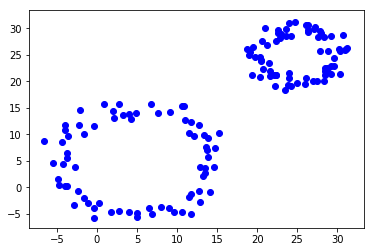

In [5]:
xk_outliers = build_circle(R,xc,std=1,outliers=True,outliers_ratio=0.05)

In [6]:
def build_data_matrix(xk,w=None):
    z = np.sum(xk**2,axis=0)
    ones = np.ones(z.shape)
    Z = np.vstack((z,xk,ones))
    if isinstance(w,np.ndarray):
        Z=w*Z
    return Z

In [7]:
def fit_circle(xk,w=None):
    k = xk.shape[1]
    
    if isinstance(w,np.ndarray):
        w = w
        s = np.sum(w)
    else:
        w = np.ones(k)
        s = k
        
    Z = build_data_matrix(xk,w)

    M = (1/s)*Z.dot(Z.T)

    N = np.array([[0,0,0,-2],[0,1,0,0],[0,0,1,0],[-2,0,0,0]])

    N_inv = np.array([[0,0,0,-1/2],[0,1,0,0],[0,0,1,0],[-1/2,0,0,0]])

    U,S,V = np.linalg.svd(N_inv.dot(M))

    return V[-1,:]

In [8]:
class circle_LS:
    def __init__(self,xk=None):
        self.xk = xk
    def fit(self,xk,w=None):
        self.xk = xk
        self.Z = build_data_matrix(xk)
        self.p = fit_circle(xk,w)
        self.R,self.xc = circle_params(self.p)
    
    def get_ek(self):
        return self.Z.T.dot(self.p)
    
    def plot(self,title='fitted circle'):
        plt.title(title)
        plot_circle_from_params(self.p,c='r')
        plt.scatter(self.xk[0,:],self.xk[1,:])

In [9]:
circle = circle_LS()

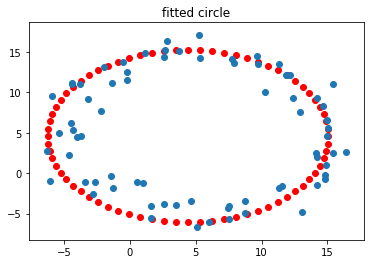

In [10]:
circle.fit(xk)
circle.plot()

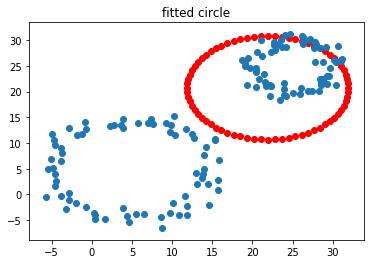

In [11]:
circle.fit(xk_outliers)
circle.plot()

In [12]:
print('RADIUS--circle: {}'.format(R))
print('RADIUS--fitted circle: {}'.format(circle.R))

RADIUS--circle: 10
RADIUS--fitted circle: 10.049975437336569


In [13]:
print('CENTER--circle: {}'.format(xc))
print('CENTER--fitted circle: {}'.format(circle.xc))

CENTER--circle: [5 5]
CENTER--fitted circle: [20.71331244 21.9183292 ]


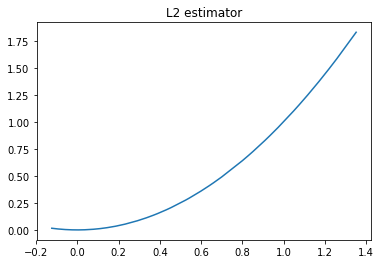

In [14]:
plt.title('L2 estimator')
ek = np.sort(circle.get_ek())
plt.plot(ek,ek**2)

## IRLS - Iteractive reweighted least squares algorithm

In [15]:
class circle_fitting:
    def __init__(self,xk=None,p=None,sig=1):
        self.sig = sig
        self.xk = xk
        self.p=p
        self.K = xk.shape[1]
        
    def fit(self,xk=None,w=None):
        
        if isinstance(xk,np.ndarray):
            xk = xk
        else:
            xk = self.xk
        
        self.Z = build_data_matrix(xk)
        self.p = fit_circle(xk,w)
        self.R,self.xc = circle_params(self.p)
    
    def fit_irls(self):
        self.fit()
        w = self.weights()
        for i in range(35):
            self.fit(w=w)
            w = self.weights()
            
    def ek(self):
        return self.Z.T.dot(self.p)
    
    def rho_gm(self):
        ek = self.ek()
        return ek**2/(ek**2+self.sig**2)
    
    def weights(self):
        ek = self.ek()
        return 2*self.sig**2/(ek**2+self.sig**2)**2  
    
    def crt(self):
        print('--Objective:{} --K:{}'.format(np.sum(self.rho_gm()),self.K))
    
    def plot(self,title='fitted_circle'):
        plt.figure()
        plot_circle_from_params(self.p,c='r')
        plt.scatter(self.xk[1,:],self.xk[0,:])
        
        
    def plot_error(self,title='objective versus error_plot'):
        plt.title(title)
        plt.scatter(circle.ek(),circle.rho_gm())
        

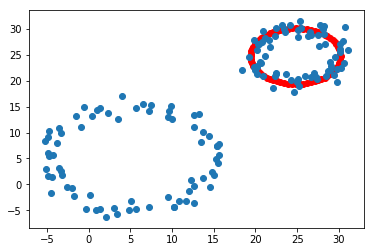

In [16]:
xk_outliers = build_circle(R,xc,std=1,outliers=True,outliers_ratio=0.09,plot=False)
circle = circle_fitting(xk_outliers,sig=0.2)
circle.fit_irls()
circle.plot()

In [17]:
circle.crt()

--Objective:62.228643345105695 --K:144


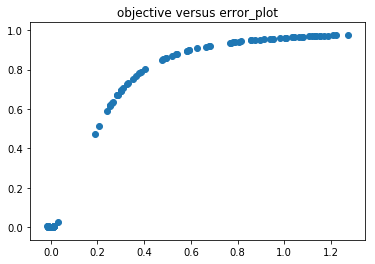

In [18]:
circle.plot_error()

In [20]:
import pickle
f = open('data/coin_data/edgels.pickle','rb')
data = pickle.load(f)
f.close()

/home/robinson/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


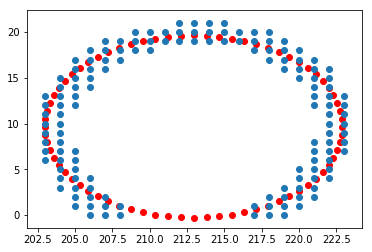

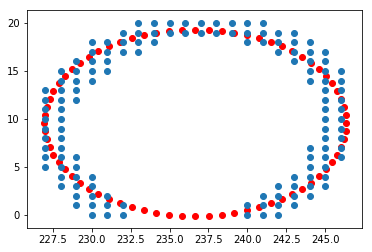

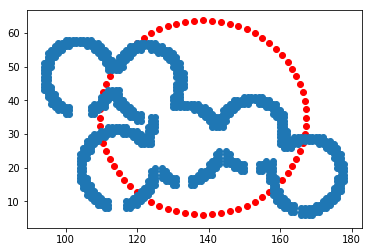

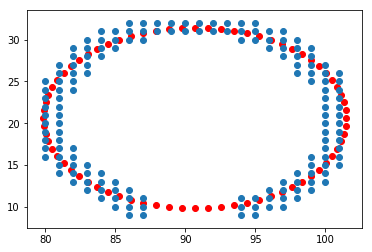

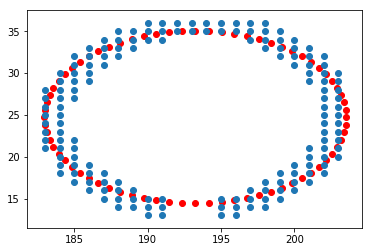

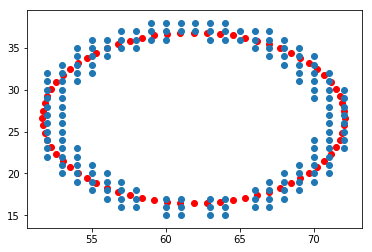

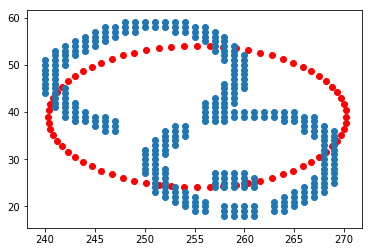

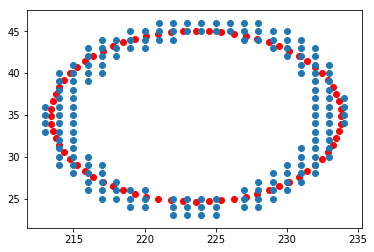

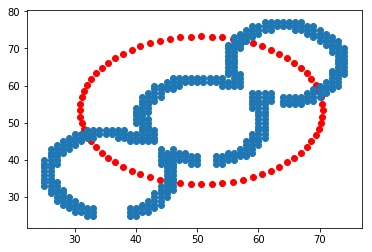

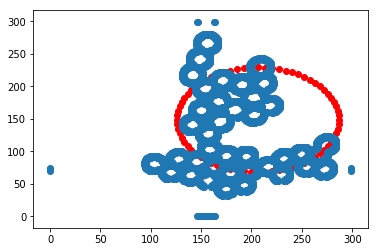

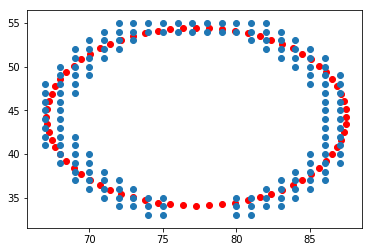

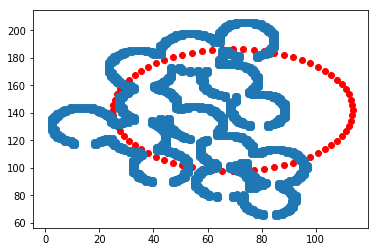

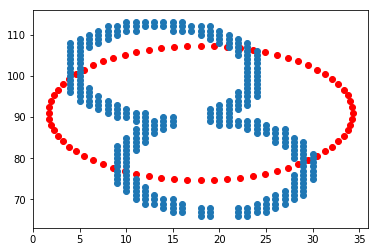

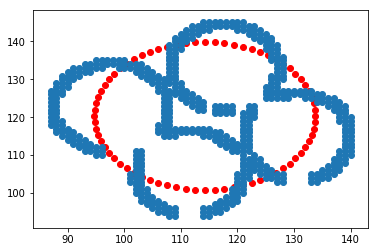

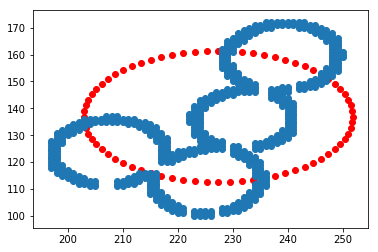

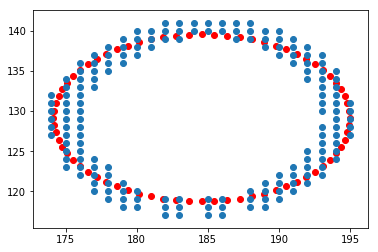

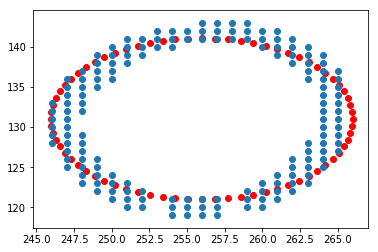

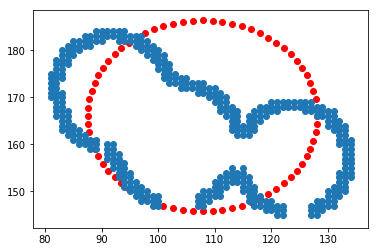

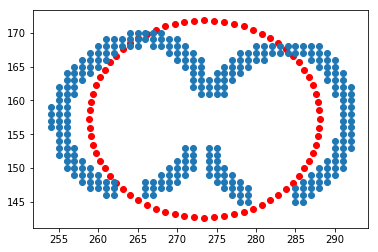

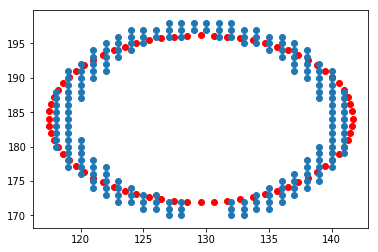

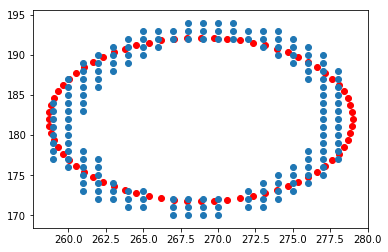

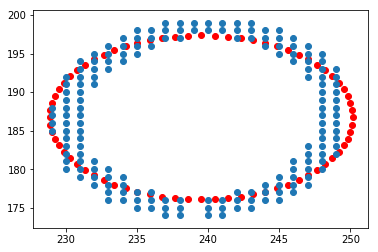

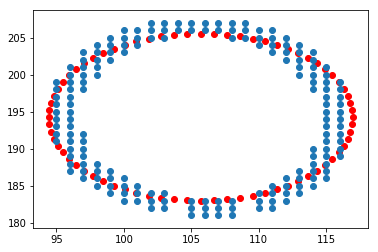

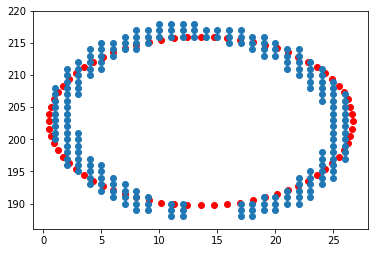

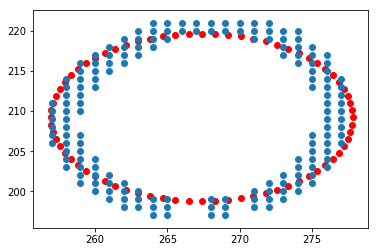

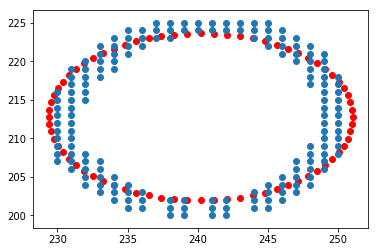

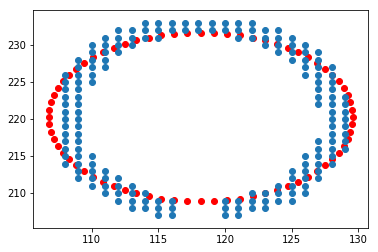

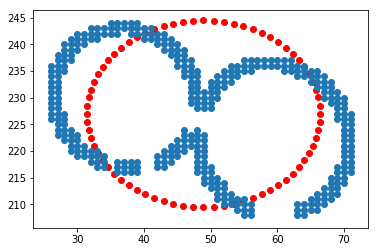

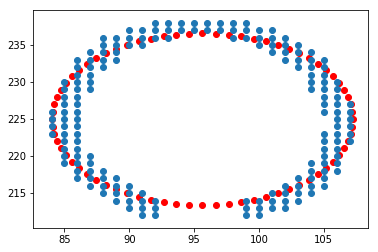

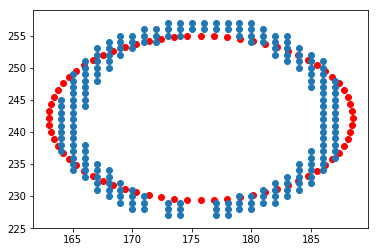

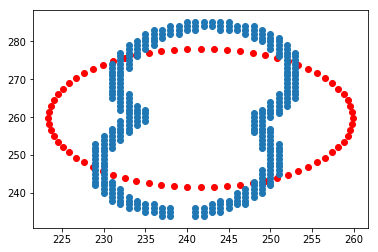

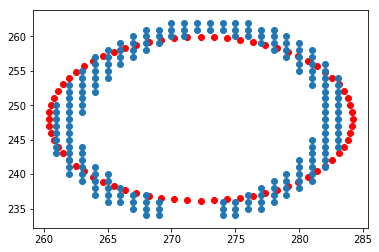

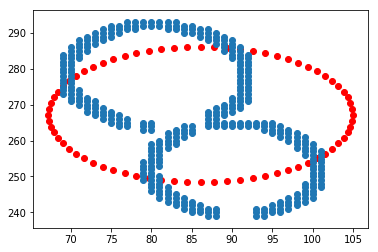

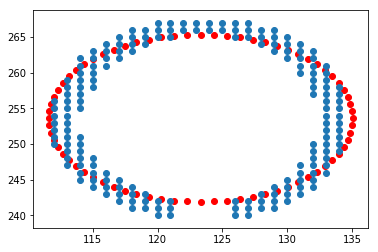

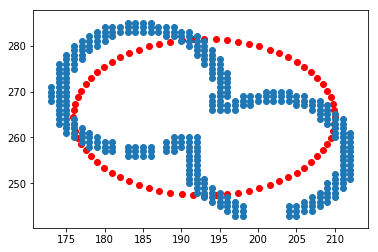

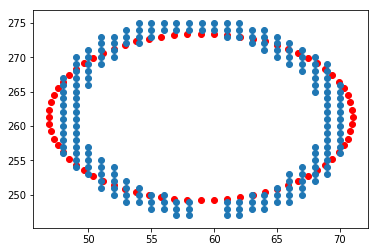

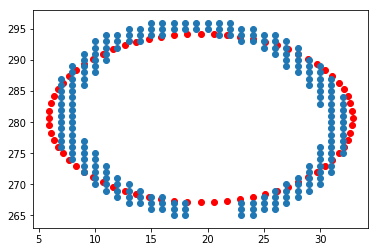

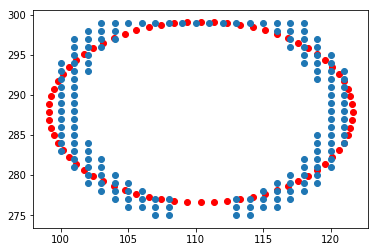

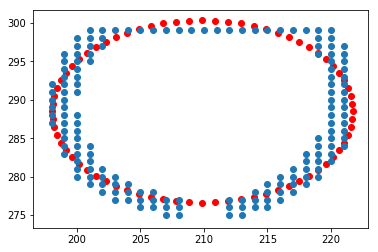

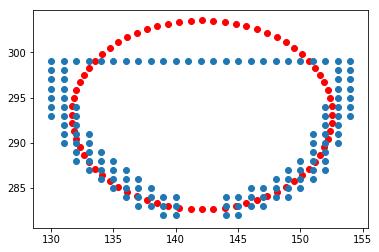

In [30]:
for k in data['kps'].keys():
    if k==0:
        continue
    circle = circle_fitting(np.array(data['kps'][k]),sig=75)
    circle.fit_irls()
    circle.plot()